In [132]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle as pkl
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
from notebook_utils import *
from parameter_estimation import load_data_util
import numpy as np
import pandas as pd
import snap
import operator
from sklearn import metrics
import networkx as nx
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif', size='15') # controls default text sizes
plt.rc('xtick', labelsize='15')
plt.rc('ytick', labelsize='15')
plt.rc('legend', fontsize='15') # legend fontsize
plt.rc('axes', labelsize='15', titlesize='15')  # fontsize of the x and y labels # fontsize of the axes title
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# List of gt fake seeds

In [2]:
# engagement counts (read cascades)
data_dir = '../data/tma/'
cascades_file = data_dir + 'cascades.txt'
labels_file = data_dir + 'labels.txt'
train_cascades = np.array(read_cascades_file(cascades_file))
train_labels = np.loadtxt(labels_file)
fake_ind, true_ind = np.where(train_labels == 1)[0], np.where(train_labels == 0)[0]
fake_cascades, true_cascades = train_cascades[fake_ind], train_cascades[true_ind]
print('num cascades', len(train_cascades), len(train_labels))

list_gt_fake_seeds = []
for fake_cas in fake_cascades:
    list_gt_fake_seeds += [int(s) for s in fake_cas[0:1, 0]]
print(list_gt_fake_seeds)

num cascades 992 992
[21262943, 325838100, 3221755357, 114202485, 22964326, 200165641, 2275780065, 274699227, 24452368, 274807042, 82984457, 18313077, 2275780065, 1545638624, 500304616, 160273215, 528863332, 3194899940, 2814849120, 17042353, 23930331, 73498797, 35366953, 22957748, 2750405587, 1442415500, 17042353, 738896052, 2985934030, 435192415, 15360796, 278818249, 772793874, 1179710990, 966553273, 253583989, 531351424, 388347822, 14294848, 395132433, 177931923, 1089225517, 2859372870, 2788058135, 526739638, 2225932904, 211620426, 539965863, 195374978, 1078284426, 1435067552, 1410841838, 34228182, 48816413, 49756651, 19861848, 316091748, 1079818927, 1910919804, 180524193, 1395014402, 1267296283, 23034673, 58738054, 370904237, 70595781, 1345822466, 128265315, 64009474, 1266239359, 21897000, 84165093, 22573068, 49462047, 48612066, 3228204548, 2775996927, 304196225, 376451651, 191200218, 3300716229, 14844715, 2527758476, 2941409994, 23445502, 17042353, 3167416055, 54509455, 340026203, 

# Intervention comparisons (Node)

In [137]:
# REWARD = |Decrease in avg size of fake cascades - Decrease in avg size of true cascades compared to no intervention| 
# R = (E[f(S_fake)] - E[f_interventionpolicy(S_fake)]) + (E[f_int(S_true) - E[f(S_true)]])

def get_exp_cascade_size(set_cascades):
    cas_len = [len(cas) for cas in set_cascades]
    return np.mean(cas_len)

def run_intervention_exp_cascade_size(removed_users, set_cascades):
    tot = 0.0
    set_removed_users = set(removed_users)
    for cas in set_cascades:
        for i, user in enumerate(cas[:,0]):
            if int(user) in set_removed_users:
                break
        tot += i  # new cascade size (when cascade is terminated at removed user)
    return tot/len(set_cascades)

def calculate_reward(ef, et, ef_int, et_int):
    # ef_intervention < ef (reduces after intervention => good thing, positive reward)
    return (ef - ef_int), (et - et_int), (ef - ef_int) + (et_int - et)


def get_topK_fake_users_from_pred_fake_cascades(preds, train_cascades):
    # utils: other baselines (in fake cascades assigned by unsupervised baselines, identify top K users to remove by eng count.)
    pred_fake_ind = np.where(preds == 1)[0]
    # print(pred_fake_ind)
    pred_fake_cascades = train_cascades[pred_fake_ind]
    u_t, u_f, sorted_u = eng_count(pred_fake_cascades, np.ones(len(pred_fake_cascades)))
    # top_users = sorted_u[:, 0]
    top_fake_users = np.array(sorted(u_f.items(), key=operator.itemgetter(1), reverse=True), dtype=np.int32)[:, 0]
    return top_fake_users

def seiz_get_pred_fake_cascades(seiz_results_file, train_cascades):
    """ SEIZ CALC
    """
    rdf = pd.read_csv(seiz_results_file, sep='\t')
    # print(rdf.head())
    scores = np.array(rdf['scores'])
    ground = np.array(rdf['ground_labels'], dtype=np.int32)
    th = np.median(scores)
    print('SEIZ threshold', th)
    preds = 1-(scores >= th)*1
    # do not use the stored predicted_labels (they are computed based on avg score thr instead of median)
    print(metrics.classification_report(ground, preds))
    seiz_top_fake_users = list(get_topK_fake_users_from_pred_fake_cascades(preds, train_cascades))
    return seiz_top_fake_users

def somebaselines_get_pred_fake_cascades(method_name, pred_file, train_cascades, train_labels):
    print(method_name)
    preds = np.loadtxt(pred_file)
    print(metrics.classification_report(train_labels, preds))
    top_fake_users = list(get_topK_fake_users_from_pred_fake_cascades(preds, train_cascades))
    return top_fake_users
          

def node_intervention_dataset(cascades_file, labels_file):
    # read files
    train_cascades = np.array(read_cascades_file(cascades_file))
    train_labels = np.loadtxt(labels_file)
    print(len(train_cascades), len(train_labels))
    # print(train_labels)
    fake_ind, true_ind = np.where(train_labels == 1)[0], np.where(train_labels == 0)[0]
    fake_cascades, true_cascades = train_cascades[fake_ind], train_cascades[true_ind]
    print('num cascades', len(train_cascades), len(train_labels))
    u_t, u_f, sorted_u = eng_count(train_cascades, train_labels)
    top_users = sorted_u[:, 0]
    top_fake_users = np.array(sorted(u_f.items(), key=operator.itemgetter(1), reverse=True), dtype=np.int32)[:, 0]
    return train_cascades, fake_cascades, true_cascades, top_users, top_fake_users, train_labels
        
        
#     print('true infl:')
#     for t in true_infl[:35]:
#         if t in u_f: print('uf', t, u_f[t])
#         # else: print('uf', t)
#         if t in u_t: print('ut', t, u_t[t])
#         # else: print('ut', t)
            
#     print('break: fake infl')
#     for f in fake_infl[:35]:
#         if f in u_f: print('uf', f, u_f[f])
#         # else: print('uf', f)
#         if f in u_t: print('ut', f, u_t[f])
#         # else: print('ut', f)
# def mic_get_pred_fake_cascades(train_cascades, train_labels):
#     data="../output/all_kwon/kwon/resp.txt"  # gamma_0, gamma_1, targets, filtered_train_cids
#     # data="../output/all_tma/tma_E/resp.txt"
#     filtered_train_cids = np.loadtxt(data, dtype=np.int32)[:, 3]
#     # print(filtered_train_cids)
#     gamma_1 = np.loadtxt(data)[:, 1]
#     # print(gamma_1)
#     preds = (gamma_1 < 0.5)*1
#     print(len(preds), len(train_cascades))
#     print(metrics.classification_report(train_labels[filtered_train_cids], preds))
    
    
#     # add zero_pred
#     more_preds = np.ones(len(train_labels))
#     more_preds[filtered_train_cids] = preds
#     print(len(more_preds), len(train_cascades))
#     print('TOOOOOOOOOO')
#     print(metrics.classification_report(train_labels, more_preds))
    
#     top_fake_users = list(get_topK_fake_users_from_pred_fake_cascades(more_preds, train_cascades))
#     # print(top_fake_users[0:35])
#     return top_fake_users

In [134]:


def run_node_intervention_all_baselines(fake_infl, true_infl, fake_component, cascades_file, labels_file, userfeat_file, seiz_results_file, kmeans_pred_file, stanceeval_pred_file, tf_pred_file):
    # baselines: MIC (top fake infl), top true infl, top users, seiz 
    train_cascades, fake_cascades, true_cascades, \
        top_users, top_fake_users, train_labels = node_intervention_dataset(cascades_file, labels_file)
    topFol = get_top_follower_users(cascades_file, userfeat_file)
    
    seiz_top_fake_users = seiz_get_pred_fake_cascades(seiz_results_file, train_cascades)
    kmeans_top_fake_users = somebaselines_get_pred_fake_cascades('KMEANS', kmeans_pred_file, train_cascades, train_labels)
    stanceeval_top_fake_users = somebaselines_get_pred_fake_cascades('STANCEEVAL', stanceeval_pred_file, train_cascades, train_labels)
    tf_top_fake_users = somebaselines_get_pred_fake_cascades('TF', tf_pred_file, train_cascades, train_labels)

    print('\nNO INTERVENTION (Exp fake cascade size), (Exp true cascade size):')
    ef = get_exp_cascade_size(fake_cascades)
    et = get_exp_cascade_size(true_cascades)
    print('ef, et', ef, et)
    
    list_K = [5, 10, 15, 20, 25, 30, 35]
    list_baseline_names = ['MIC', 'TopU', 'SEIZ', 'K-Means', 'StanceEval', 'TF', 'TopFol']
    gains, losses, totrewards = [], [], []

    for b, baseline in enumerate(list_baseline_names):
        gains.append([0]*len(list_K)); losses.append([0]*len(list_K)); totrewards.append([0]*len(list_K))
    
    for ik, K in enumerate(list_K):
        # print('\n=======K=========', K)
        
        list_removed_users_baselines = []  # maintain in order of list_baseline_names
        list_removed_users_baselines.append(fake_infl[:K]) # MIC
        list_removed_users_baselines.append(top_users[:K])
        list_removed_users_baselines.append(seiz_top_fake_users[:K])
        list_removed_users_baselines.append(kmeans_top_fake_users[:K])
        list_removed_users_baselines.append(stanceeval_top_fake_users[:K])
        list_removed_users_baselines.append(tf_top_fake_users[:K])        
        list_removed_users_baselines.append(topFol[:K])
        
        for baseline_no, removed in zip(np.arange(len(list_baseline_names)), list_removed_users_baselines):
            ef_int = run_intervention_exp_cascade_size(removed, fake_cascades)
            et_int = run_intervention_exp_cascade_size(removed, true_cascades)
            rewards = calculate_reward(ef, et, ef_int, et_int)
            gains[baseline_no][ik] = 1.0 * rewards[0]/ef
            losses[baseline_no][ik] = 1.0 * rewards[1]/et
            totrewards[baseline_no][ik] = rewards[2]
            print('ef_int, et_int', ef_int, et_int, rewards)
    
    print('done intervention')
    results = [gains, losses, totrewards]
    
    return list_K, list_baseline_names, results


    #     print('\nINTERVENTION: REMOVE K TOP FAKE USERS:')
    #     ef_int = run_intervention_exp_cascade_size(top_fake_users[:K], fake_cascades)
    #     et_int = run_intervention_exp_cascade_size(top_fake_users[:K], true_cascades)
    #     print('ef_int, et_int', ef_int, et_int, calculate_reward(ef, et, ef_int, et_int))

    #     print('\nINTERVENTION: REMOVE ANY K RAND USERS:')
    #     # np.random.seed(0)
    #     avg_ef_int, avg_et_int = [], []
    #     for r in range(20):
    #         random_removed = np.random.choice(top_users, K)
    #         ef_int = run_intervention_exp_cascade_size(random_removed[:K], fake_cascades)
    #         et_int = run_intervention_exp_cascade_size(random_removed[:K], true_cascades)
    #         # print('ef_int, et_int', ef_int, et_int, calculate_reward(ef, et, ef_int, et_int))
    #         avg_ef_int.append(ef_int); avg_et_int.append(et_int)
    #     ef_int, et_int = np.mean(avg_ef_int), np.mean(avg_et_int)
    #     print('ef_int, et_int', ef_int, et_int, calculate_reward(ef, et, ef_int, et_int))

    #     print('\nINTERVENTION: REMOVE ANY K INFL USERS:')
        # np.random.seed(0)
    #     avg_ef_int, avg_et_int = [], []
    #     for r in range(50):
    #         random_removed = np.random.choice(true_infl + fake_infl, K)
    #         ef_int = run_intervention_exp_cascade_size(random_removed[:K], fake_cascades)
    #         et_int = run_intervention_exp_cascade_size(random_removed[:K], true_cascades)
    #         # print('ef_int, et_int', ef_int, et_int, calculate_reward(ef, et, ef_int, et_int))
    #         avg_ef_int.append(ef_int); avg_et_int.append(et_int)
    #     ef_int, et_int = np.mean(avg_ef_int), np.mean(avg_et_int)
    #     print('ef_int, et_int', ef_int, et_int, calculate_reward(ef, et, ef_int, et_int))


In [150]:
p = pd.read_pickle('twitter-ma/tweet_dict_ids.pkl')

In [168]:
dict_tma_fol = {}

for k,v in p.items():
    for u, f in zip(v['uid'], v['usr_fol_num']):
        dict_tma_fol[float(u)] = f


In [171]:

def get_top_follower_users(cascades_file, userfeat_file):
    train_cascades = np.array(read_cascades_file(cascades_file))
    if userfeat_file is None:
        fol = dict_tma_fol
    else:
        df = pd.read_csv(userfeat_file, sep='\t', header=None)
        fol = dict(zip(df[0], df[1]))
    users = set()
    for s in train_cascades:
        users.update(list(s[:,0]))
    list_u = list(users)
    list_f = list()
    for u in list_u:
        list_f.append(fol[u])
    sorted_u = [u for f, u in sorted(zip(list_f, list_u), reverse=True)]
    sorted_f = [f for f, u in sorted(zip(list_f, list_u), reverse=True)]
    return sorted_u


def run_node_intervention():

    """ INPUT FILES LIST (KWON)
    """
    # fake_infl = [39357, 41645179, 51828921, 1688, 41625921, 904660, 55640892, 45357704, 117511, 31745148, 49130864, 46283660, 31441663, 46161420, 54595164, 39025741, 16983873, 10045, 51489852, 53382638, 19771216, 18987, 85853, 39003758, 26101679, 54795103, 31749799, 40531228, 11402038, 31665361, 2187715, 54888609, 55762225, 12919420, 26206026, 15191995, 44083204, 9866568, 892, 33019416, 4270645, 36020039, 47509244, 49614, 51093837, 45924090, 599, 9581, 34949244, 30715157, 52174399, 34664714, 40179, 45241472, 600250, 26869787, 33498358, 88703, 45887855, 46849, 34753016, 12186498, 56001060, 81502, 10179069, 10054, 25980076, 37733084, 28768064, 51631070, 29708909, 23813323, 46643782, 56009279, 46060230, 2447156, 40134854, 55922657, 17236288, 39758253, 73058, 14808579, 36503735, 43569984, 2267067, 32691858, 41792135, 34882960, 25900052, 47386549, 46730408, 12944483, 9456, 34949531, 10278418, 29030843, 45708734, 15035771, 47419769, 1761233]
    fake_infl = [42921853, 45696250, 9428477, 18485804, 37484955, 15538468, 34544545, 80876, 54879, 33361052, 37232745, 33603546, 1680247, 40864273, 134, 20164964, 29144327, 1883240, 47924370, 24916432, 35560818, 15554302, 773, 5272341, 29507615, 29156372, 38769438, 34345266, 2233, 8627533, 14611855, 32269208, 49726906, 28193335, 8098832, 12200968, 55903340, 47588713, 31917878, 19707732, 46248155, 33910097, 55976845, 27047346, 47386549, 9910421, 22678269, 44147043, 35379119, 51841996, 20795579, 37955867, 1002, 46900340, 48467139, 55970765, 17866088, 20853985, 21684, 55972805, 17281580, 18797761, 47872293, 22601310, 7148912, 43816406, 103535, 30331073, 27958549, 17119043, 34686602, 30721844, 28131892, 12068845, 18035830, 27104465, 22978489, 47977103, 46730321, 43369375, 43756699, 12186498, 19444022, 61280, 41050967, 31441663, 42926119, 55991030, 10688944, 16358632, 23219078, 5297007, 2150040, 35332369, 5773920, 68059, 42401663, 27547127, 15491837, 4667953]
    # true_infl = [41645179, 51828921, 53471447, 46161420, 54888609, 31745148, 31441663, 117511, 904660, 18987, 15446395, 44282988, 53382638, 51489852, 48439353, 1709, 85853, 26206026, 25532591, 54425344, 45062504, 17512677, 39003758, 31665361, 31749799, 1217410, 2447156, 19771216, 31572449, 15191995, 2187715, 53272550, 48455831, 20155, 16757978, 12919420, 47110694, 44083204, 28555, 45708734, 30889300, 41792135, 1041957, 45887855, 49614, 33603546, 55922657, 13080305, 14808579, 48151623, 892, 73058, 4270645, 61994, 33986646, 46060230, 46849, 47419769, 34891224, 45241472, 48428454, 10278418, 25980076, 48872364, 35478, 31318992, 43981298, 51093837, 55848798, 34711253, 13420494, 9456, 443113, 37484955, 46730408, 5770411, 46931589, 8990, 26101679, 40125, 37733084, 41736970, 53703886, 46295098, 32691858, 37471, 7836260, 27747934, 55778501, 16983873, 26385432, 40864273, 40179, 34882960, 48350639, 46493916, 47386549, 27588149, 31480592, 40074055]
    true_infl = [30122132, 9456, 1041957, 55931092, 52656642, 51298452, 2329550, 74679, 9761160, 42598690, 12987474, 1083172, 25480395, 24007123, 53616317, 6934529, 22041886, 25869801, 20510188, 37057701, 42946550, 23803578, 21417341, 31665361, 29264958, 16639123, 28117383, 5396879, 30971958, 23086420, 28776904, 80876, 40591, 49782598, 48911973, 10501473, 9022728, 11494548, 47350415, 55774980, 39515674, 42837, 17072, 49272331, 81419, 42760, 24058200, 10041, 30404702, 6365957, 11749083, 25672074, 14748530, 52263483, 166747, 45543326, 15315324, 20716299, 5903540, 34420488, 40075183, 23246755, 56017762, 43560260, 15191995, 33786128, 360451, 25200040, 16939, 23539100, 16759010, 56023202, 3420957, 9645533, 55935602, 41127254, 7414712, 54917, 52244910, 42976, 29156372, 24773084, 32106161, 35444685, 40176, 46945086, 54780470, 80877, 49755942, 19047950, 9656071, 38410, 11209421, 6481132, 49614, 35775165, 21719470, 22525981, 65561, 825]
    
    fake_component = 0

    # engagement counts (read cascades)
    data_dir = '../data/kwon/'
    cascades_file = data_dir + 'cascades.txt'
    labels_file = data_dir + 'labels.txt'  
    userfeat_file = 'sub_user_info_share.txt'

    seiz_results_file = 'mic_kdd_inflmax/netinf_kdd_logs/kwon/seiz_results_3.txt'
    kmeans_pred_file ="../output/baselines/kwon/kmeans_pred_results.txt"
    stanceeval_pred_file = "../output/baselines/kwon/stanceeval_pred_results.txt"
    tf_pred_file = "../output/baselines/kwon/tf_pred_results.txt" # "../output/baselines/kwon/tf_pred_results.txt"
    list_K, list_baseline_names, kwon_results = run_node_intervention_all_baselines(fake_infl, true_infl, fake_component, cascades_file, labels_file, userfeat_file, seiz_results_file, kmeans_pred_file, stanceeval_pred_file, tf_pred_file)

    """ INPUT FILES LIST (TMA)
    """
    
    fake_infl = [182741872, 2388958777, 2580423060, 3438202888, 169954894, 1957558952, 64722130, 3212620271, 200435698, 582852483, 1389882727, 2416484101, 15521321, 3107909896, 1473389984, 3034853732, 540417242, 335461141, 1611858558, 125128428, 1280124271, 834953227, 248774714, 2886612620, 52865869, 49249409, 166206898, 15359014, 149981362, 2799603473, 1443132836, 922576634, 340789196, 138224000, 269334836, 3212596827, 1358201918, 321659355, 17703035, 123078358, 174102086, 3312233855, 631625137, 3272415836, 134240162, 765763200, 2203400720, 973546771, 724292641, 25236548, 104403350, 91609427, 267080200, 253633235, 947703439, 36539277, 1258761552, 588945219, 1229771844, 605487886, 90497896, 3081433067, 365214457, 15024705, 47332651, 622632971, 151579111, 499073057, 930575720, 576358484, 2376460524, 2338792994, 996430604, 2886787275, 127464003, 72882689, 2493044713, 486835275, 3177696986, 323515127, 973526730, 2591942665, 1703530184, 18085871, 17882093, 2904322704, 559437083, 3044646683, 21729540, 1258148130, 2942634366, 1073562656, 57388012, 435625148, 3349946379, 366974308, 77357964, 900732667, 505294099, 118024534]
    true_infl = [339429052, 15613203, 980941849, 210778303, 280122911, 386275837, 1662872534, 3044768385, 32658668, 546744362, 1624306176, 2203759645, 2385911990, 223432445, 2975722854, 3213005087, 46483345, 1383135966, 17115595, 73690963, 1652772608, 1036461709, 544380588, 247599114, 2408397397, 603440278, 3110930003, 384942394, 1424642856, 2388970874, 2388915241, 76908897, 374578350, 172106013, 427253416, 1160935351, 20850076, 30569506, 2538790446, 1938037314, 22225065, 1121790673, 370269230, 1484946193, 315577705, 308174015, 385394323, 3293377954, 1979279791, 3318477709, 2877872245, 1582545024, 243351447, 1526305728, 3177614538, 1253082505, 444898632, 52865869, 248774714, 1592407585, 3177760471, 186043413, 257517997, 456328773, 3177720054, 243264343, 190222885, 1181597546, 3044646683, 2203738322, 3040474978, 196264273, 975829939, 2215526899, 43600056, 1736506310, 626391901, 529622870, 2203707510, 31147225, 325327587, 717582870, 1572958224, 1557035341, 163364458, 2952724430, 1177641950, 32497478, 559799896, 2773297820, 507877806, 17285050, 2615420165, 51210644, 138221035, 603540902, 2956463164, 2209207302, 2362308738, 3212854007]
    
    fake_component = 0

    # engagement counts (read cascades)
    data_dir = '../data/tma/'
    cascades_file = data_dir + 'cascades.txt'
    labels_file = data_dir + 'labels.txt'
    userfeat_file = 'twitter-ma/tweet_dict_ids.pkl'
        
    seiz_results_file = 'code_base_unfinished/mic_kdd_inflmax/netinf_kdd_logs/twitter-ma/seiz_results.txt'
    kmeans_pred_file ="../output/baselines/tma/kmeans_pred_results.txt"
    stanceeval_pred_file ="../output/baselines/tma/stanceeval_pred_results.txt"
    tf_pred_file = "../output/baselines/tma/tf_pred_results.txt"

    list_K, list_baseline_names, tma_results = run_node_intervention_all_baselines(fake_infl, true_infl, fake_component, cascades_file, labels_file, None, seiz_results_file, kmeans_pred_file, stanceeval_pred_file, tf_pred_file)

    return list_K, list_baseline_names, kwon_results, tma_results

list_K, list_baseline_names, kwon_results, tma_results = run_node_intervention()

111 111
num cascades 111 111
t/f 51 60
u_t, u_f, tot 76041 47869 123910
users large eng > 5 2457
users large eng > 10 871
SEIZ threshold 0.21876084880547408
              precision    recall  f1-score   support

           0       0.50      0.55      0.52        51
           1       0.58      0.53      0.56        60

    accuracy                           0.54       111
   macro avg       0.54      0.54      0.54       111
weighted avg       0.54      0.54      0.54       111

t/f 0 55
u_t, u_f, tot 0 54517 54517
users large eng > 5 1199
users large eng > 10 401
KMEANS
              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65        51
         1.0       0.82      0.15      0.25        60

    accuracy                           0.52       111
   macro avg       0.65      0.56      0.45       111
weighted avg       0.67      0.52      0.44       111

t/f 0 11
u_t, u_f, tot 0 180 180
users large eng > 5 0
users large eng > 10 0
STANCEEVAL
      

In [172]:
print(list_K, list_baseline_names, len(tma_results[0])) # gains, losses, totrewards -> each baseline result

[5, 10, 15, 20, 25, 30, 35] ['MIC', 'TopU', 'SEIZ', 'K-Means', 'StanceEval', 'TF', 'TopFol'] 7


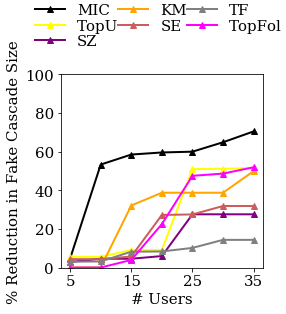

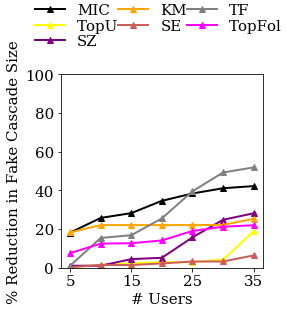

In [174]:
""" PLOT NODE INTERVENTION RESULTS
"""

def plot_func(gains):

    # list_K, list_baseline_names, results = run_node_intervention_all_baselines()
    # gains, losses, totrewards = results
    colors = ['black', 'yellow', 'purple', 'orange', 'indianred', 'gray', 'magenta']
    # print(list_baseline_names)
    list_baseline_names[0] = 'MIC'
    list_baseline_names[1] = 'TopU'
    list_baseline_names[2] = 'SZ'
    list_baseline_names[3] = 'KM'
    list_baseline_names[4] = 'SE'
    list_baseline_names[5] = 'TF'
    list_baseline_names[6] = 'TopFol'
    # plot gains

    fig, axs = plt.subplots(1, 1, figsize=(4,4))
    axs = [axs]
    l = [0]*len(gains)
    for i in range(len(list_baseline_names)):
        l[i] = axs[0].plot(gains[i], marker='^', color=colors[i], label=list_baseline_names[i], linewidth=2)
    #     axs[1].plot(losses[i], marker='^', color=colors[i])

        axs[0].set_yticks(np.arange(0, 1.1, 0.2)) # fontsize=15)
        axs[0].set_yticklabels(np.arange(0, 101, 20))
        axs[0].set_ylim(0, 1.0) # plt.ylim(0, 1.0)

    #     axs[1].set_yticks(np.arange(0, 1.1, 0.2)) # fontsize=15)
    #     axs[1].set_ylim(0, 1.0) # plt.ylim(0, 1.0)

    # axs[0].set_xticks(np.arange(len(list_K)))
    axs[0].set_xticklabels(['', '5', '15', '25', '35']); # axs[1].set_xticklabels([0] + list_K)
    axs[0].set_xlabel('# Users'); # axs[1].set_xlabel('# Users Removed')
    axs[0].set_ylabel('% Reduction in Fake Cascade Size') 
    # axs[1].set_ylabel('Reduction in True Cascade Size')

    # axs[0].set_title('Twitter-1', loc='center') # -0.01)
    # axs[1].set_title('Twitter-2', loc='center') # -0.01)

    # plt.xticks(range(3), ['100', '1K', '2K', '3K', '4K', '5K'])
    fig.legend(l, labels=list_baseline_names, loc='center', bbox_to_anchor= (0.55, 1), ncol=3, borderaxespad=-4, frameon=False, columnspacing=0, labelspacing=0.1) # prop={'size': 10})
    # fig.legend(loc='upper right', labelspacing=0.2)
    plt.tight_layout()
    # plt.savefig("newrec", bbox_inches='tight')

plot_func(kwon_results[0])
# plt.savefig('./nodeinterv_kwon.pdf', bbox_inches='tight')
plot_func(tma_results[0])
# plt.savefig('./nodeinterv_tma.pdf', bbox_inches='tight')


In [641]:
# """ PLOT NODE INTERVENTION RESULTS
# """
# # list_K, list_baseline_names, results = run_node_intervention_all_baselines()
# # gains, losses, totrewards = results
# colors = ['black', 'indianred', 'green', 'orange', 'purple']
# list_baseline_names[0] = 'MIC Interv. (Fake Infl)'
# # plot gains

# fig, axs = plt.subplots(1, 2, figsize=(8,4))
# l = [0]*len(gains)
# for i in range(len(list_baseline_names)):
#     l[i] = axs[0].plot(np.arange(len(list_K)), gains[i], marker='^', color=colors[i]) # label=list_baseline_names[i]
#     # axs[1].plot(losses[i], marker='^', color=colors[i])

# axs[0].set_xticklabels([0] + list_K); # axs[1].set_xticklabels([0] + list_K)
# axs[0].set_xlabel('# Users Removed'); # axs[1].set_xlabel('# Users Removed')
# axs[0].set_ylabel('Reduction in Fake Cascade Size') 
# # axs[1].set_ylabel('Reduction in True Cascade Size')
   
# axs[0].set_title('Twitter-1', loc='center') # -0.01)
# axs[1].set_title('Twitter-2', loc='center') # -0.01)

# # plt.xticks(range(3), ['100', '1K', '2K', '3K', '4K', '5K'])
# fig.legend(l, labels=list_baseline_names, loc='center', bbox_to_anchor= (0.55, 1), ncol=5, 
#             borderaxespad=-1, frameon=True)
# plt.tight_layout()
# # plt.savefig("newrec", bbox_inches='tight')
